In [20]:
import rasterio as rio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy
import seaborn as sns
from matplotlib.lines import Line2D

# RCMs color: 
color_racmo =  (208/255,28/255,31/255)
color_mar = (225/255,126/255,4/255)
color_hirham = (47/255,158/255,49/255) 
color_ens = (176/255,132/255,106/255)

# Assign color based on RCM name: 
display_colors = {"HIRHAM": color_hirham,
                "MAR": color_mar,
                "RACMO": color_racmo,
                "Ensemble mean": color_ens}

# Some settings for results: 
vmin = 0
vmax = 100
cmap = "flare_r"

def basin_statistics(mask_shp, raster):
    '''
    Function to clip a raster using a shapefile (eg. a drainage basin) and computes the mean, median, 
    standard deviation. 
    
    Input: mask_shape: geometry of the shapefile that will be used to cut the raster. 
           raster: The raster file. 
           
    Output: mean, median, standard deviation of the clipped raster 
            out_image: The raster where everything else than the basin is set to nan. 
    '''
    
    out_image, out_transform = mask(raster,[mask_shp], nodata=np.nan)
    
    return np.nanmean(out_image), np.nanmedian(out_image), np.nanstd(out_image), np.squeeze(out_image)


def find_best_model_icesheet(mean, best_def):
    '''
    Function that finds the best model based on a statistics array. 
    
    Input: mean: array with statistics icesheet wide performance of each RCM
           best_def: Defines whether the best performance is the maxarg og minarg. 
           
    output: best model for icesheet. 
    '''
    
    
    # returns the index of the best model 
    if best_def == 'min': 
        best_icesheet_model = np.argmin(np.abs(icesheet_mean))
    elif best_def == 'max':
        best_icesheet_model = np.argmax(np.abs(icesheet_mean))
    
    # what index corresponds the with model: 
    num2model = {0: "HIRHAM",
                2: "MAR", 
                1: "RACMO", 
                3: "Ensemble mean"}
    
    # Convert index into model: 
    best_icesheet_model = num2model[best_icesheet_model]
    return best_icesheet_model

def find_best_model_basins(basin_dataframe, stat_array, best_def): 
    
    '''
    Function that finds the best model for each drainage basins based on the statistics array. 
    
    Input: basin_dataframe: geopandas dataframe with basins 
           stat_array: statistics array that decribes the performance of the RCM, eg. the mean differences. 
           best_def: Defines whether the best performance is the maxarg og minarg.  
           
    Output: Updated geopandas dataframe with the best model for each basin together with the rgb code for that model.
    '''
    
    # Make a geopanda dataframe with basins and the stat array: 
    basins_updated = pd.concat([basin_dataframe, pd.DataFrame(stat_array)], axis=1)
    basins_updated.columns = ['SUBREGION1', 'geometry', 'HIRHAM', 'RACMO', 'MAR', 'Ensemble mean']
    
    # Find the best model depeing on if we want to minimize or maximize the values:
    if best_def == 'max': 
        best_model = np.abs(basins_updated.iloc[:, 2:6]).idxmax(axis = 1)
    elif best_def == 'min':
        best_model = np.abs(basins_updated.iloc[:, 2:6]).idxmin(axis = 1)

    color_best_model = [display_colors[s] for s in best_model]
    # update dataframe 
    basins_updated['best model'] = best_model
    basins_updated['best model colors'] = color_best_model
    
    return basins_updated
       
def plot_basin_stats(dataframe, RCM_name, ax, cmap, vmin, vmax, legend = False, legend_label = None): 
    
    # plot dataframe: 
    dataframe.plot(RCM_name, ax = ax, 
                   cmap=cmap,edgecolor="black", linewidth = 0.6,
                   vmin = vmin, vmax = vmax,
                   legend = legend, legend_kwds={"label": legend_label})
    # Add land feature and coastlines: 
    ax.add_feature(cartopy.feature.LAND,color = 'tan', alpha = 0.7)
    ax.coastlines(resolution='50m', linewidth = 0.1)
    
    ax.set_title(f'ASCAT - {RCM_name}', fontsize = 20)
    
    
    
    
def plot_best_model(dataframe, ax): 
    dataframe.plot(ax=ax, 
                   legend = True, 
                   color = dataframe["best model colors"], 
                   alpha = 0.8, edgecolor="black", 
                   linewidth = 0.6)
    
    # Add land feature and coastlines; 
    ax.add_feature(cartopy.feature.LAND,color = 'tan', alpha = 0.7)
    ax.coastlines(resolution='50m', linewidth = 0.1)
    # Add title: 
    ax.set_title(f'{year}')

    # add manual legend
    custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color, alpha =0.8) for color in display_colors.values()]
    leg= ax.legend(custom_points, display_colors.keys())
    leg.set_bbox_to_anchor((1., 0.8, 0.75, 0.2))
    

# Select the type of difference map, year and load data


In [3]:
# Type of difference: Difference betweem ASCAT and RCM, could be the difference between start, end duration, 
# number of melt and refressing days
type_dif = 'melt_days'
year = 2016 # Year to use 

# Load tif files with the difference maps for each of the RCMs: 
racmo_diff = rio.open(f'/home/annpug/Desktop/annpug/difference_maps/ASCAT_racmo_{type_dif}_{year}.tif')
mar_diff = rio.open(f'/home/annpug/Desktop/annpug/difference_maps/ASCAT_mar_{type_dif}_{year}.tif')
hirham_diff = rio.open(f'/home/annpug/Desktop/annpug/difference_maps/ASCAT_hirham_{type_dif}_{year}.tif')
ens_mean_diff = rio.open(f'/home/annpug/Desktop/annpug/difference_maps/ASCAT_ens_{type_dif}_{year}.tif')

# Load the shapefiles of the two different drainage basins and the icesheet:
icesheet = gpd.read_file('/home/annpug/Desktop/annpug/GRE_IceSheet_IMBIE2/GRE_icemask_epsg_3413.shp')
icesheet = icesheet[icesheet.SUBREGION1 == 'ICE_SHEET']
basins_zwally = gpd.read_file('/mnt/rsdb/data/Vectors/Greenland/OIB/IRMCR2.001/drainage_subsystem_icesat_PS.shp') 
basins_rignot = gpd.read_file('/home/annpug/Desktop/annpug/GRE_IceSheet_IMBIE2/GRE_Basins_IMBIE2_v1.3_epsg_3413.shp')
basins_rignot_icesheet = basins_rignot.iloc[51:57].reset_index(drop = True) # Since Rignot include surrounding glaciers and ice caps, they are removed here.

# Find the performing RCM icesheet wide

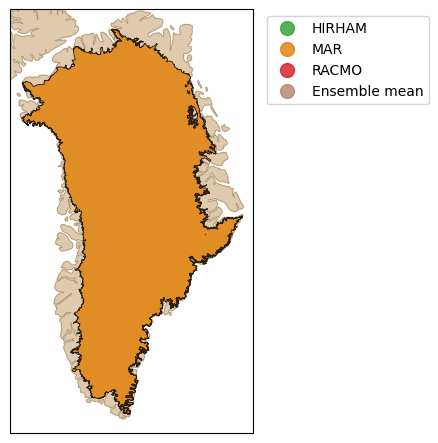

In [4]:
# Compute the mean for each RCMs: 
icesheet_mean = np.zeros(4)
icesheet_mean[0], _,_, out_hirham = basin_statistics(icesheet.iloc[0].geometry, hirham_diff)
icesheet_mean[1], _,_, out_racmo = basin_statistics(icesheet.iloc[0].geometry, racmo_diff)
icesheet_mean[2], _,_, out_mar = basin_statistics(icesheet.iloc[0].geometry, mar_diff)
icesheet_mean[3], _,_, out_racmo = basin_statistics(icesheet.iloc[0].geometry, ens_mean_diff)

# Find the best model: 
best_icesheet_model = find_best_model_icesheet(icesheet_mean, 'max')

# plot resuls: 
fig, axs = plt.subplots(1, 1, figsize = (17.5,5.5),subplot_kw={'projection': cartopy.crs.Stereographic(
                                                                                        central_longitude=-45,
                                                                                        central_latitude=90,
                                                                                        true_scale_latitude=70)})
axs.add_feature(cartopy.feature.LAND,color = 'tan', alpha = 0.7)
axs.coastlines(resolution='50m', linewidth = 0.1)
best_icesheet_model.plot(legend = True, color = display_colors[best_icesheet_model], alpha = 0.8, edgecolor="black", linewidth = 0.6, ax=axs)

# add manual legend
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color, alpha =0.8) for color in display_colors.values()]
leg= axs.legend(custom_points, display_colors.keys())
leg.set_bbox_to_anchor((1., 0.8, 0.75, 0.2))
fig.savefig(f'/home/annpug/Desktop/annpug/figures/basin_comparison_{type_dif}_{year}_icesheet.png', bbox_inches="tight")

# Rignot et al. drainage basins 

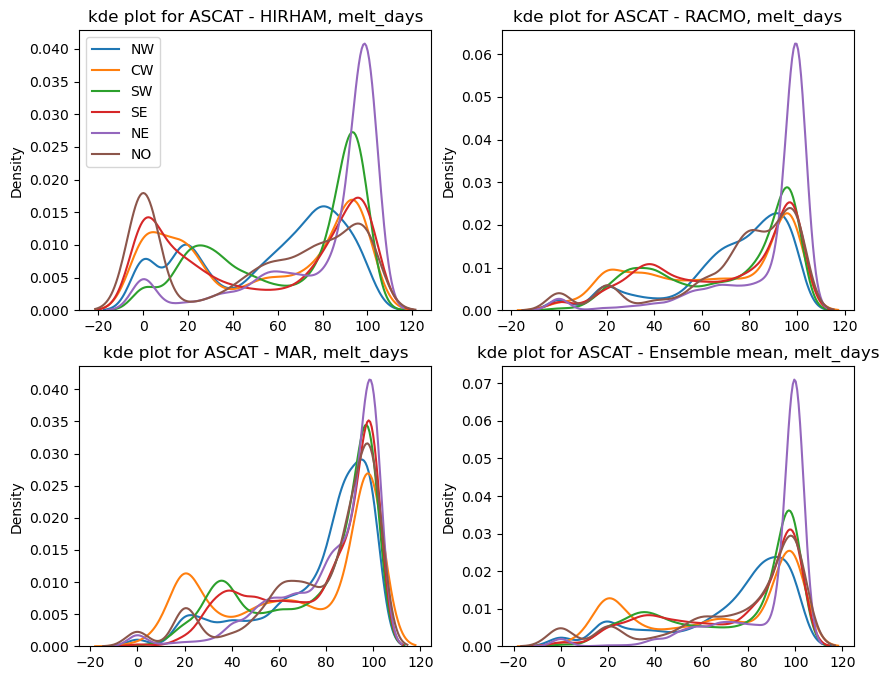

In [9]:
# Init arrays for basin stats: 
basin_mean = np.zeros((len(basins_rignot_icesheet), 4))
basin_median =  np.zeros((len(basins_rignot_icesheet), 4))
basin_std =  np.zeros((len(basins_rignot_icesheet), 4))

fig, axs = plt.subplots(2, 2, figsize = (10,8))
axs = axs.ravel()

# Compute the statistics for each basin for each model: 
for i in range(len(basins_rignot_icesheet)): 
    basin = basins_rignot_icesheet.iloc[i]
    basin_mean[i,0], basin_median[i,0],basin_std[i,0], out_hirham = basin_statistics(basin.geometry, hirham_diff)
    basin_mean[i,1], basin_median[i,1],basin_std[i,1], out_racmo = basin_statistics(basin.geometry, racmo_diff)
    basin_mean[i,2], basin_median[i,2],basin_std[i,2], out_mar = basin_statistics(basin.geometry, mar_diff)
    basin_mean[i,3], basin_median[i,3],basin_std[i,3], out_ens = basin_statistics(basin.geometry, ens_mean_diff)
    
    # Plot the distribution for each model for the given basin: 
    sns.kdeplot(out_hirham.flatten(), ax=axs[0], label = f'{basins_rignot_icesheet.SUBREGION1[i]}')
    sns.kdeplot(out_racmo.flatten(), ax=axs[1], label = f'{basins_rignot_icesheet.SUBREGION1[i]}')
    sns.kdeplot(out_mar.flatten(), ax=axs[2], label = f'{basins_rignot_icesheet.SUBREGION1[i]}')
    sns.kdeplot(out_ens.flatten(), ax=axs[3] ,label = f'{basins_rignot_icesheet.SUBREGION1[i]}')

axs[0].legend() # Add legend to one plot. 
# Add titles to each subplot: 
axs[0].set_title(f'kde plot for ASCAT - HIRHAM, {type_dif}')
axs[1].set_title(f'kde plot for ASCAT - RACMO, {type_dif}')
axs[2].set_title(f'kde plot for ASCAT - MAR, {type_dif}')
axs[3].set_title(f'kde plot for ASCAT - Ensemble mean, {type_dif}')

# Find best model based on the mean: 
updated_basins_rignot = find_best_model_basins(basins_rignot_icesheet, basin_mean, 'max')

## a) Plot of mean values for each basin 

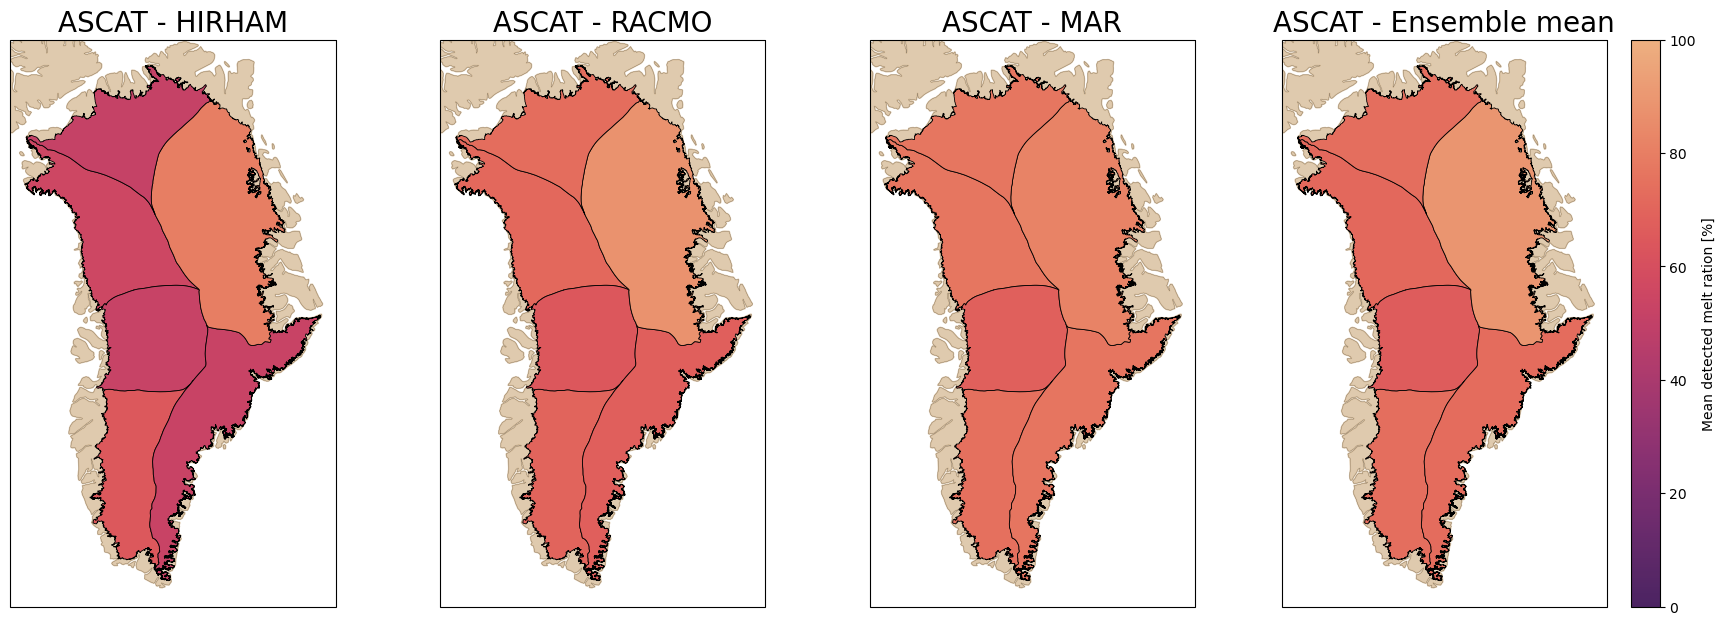

In [26]:
# Figure setup with the right projection (EPSG:3413)
fig, axs = plt.subplots(1, 4,  figsize = (17.5,5.5), subplot_kw={'projection': cartopy.crs.Stereographic(
                                                                                        central_longitude=-45,
                                                                                        central_latitude=90,
                                                                                        true_scale_latitude=70)})
# plot results: 
plot_basin_stats(updated_basins_rignot, "HIRHAM", axs[0], cmap, vmin, vmax)
plot_basin_stats(updated_basins_rignot, "RACMO", axs[1], cmap, vmin, vmax)
plot_basin_stats(updated_basins_rignot, "MAR", axs[2], cmap, vmin, vmax)
plot_basin_stats(updated_basins_rignot, "Ensemble mean", axs[3], cmap, vmin, vmax, 
                 legend = True, legend_label = "Mean detected melt ration [%]")


fig.tight_layout(pad = -2)
#fig.savefig(f'/home/annpug/Desktop/annpug/figures/basin_comparison_{type_dif}_{year}_rignot.png', bbox_inches="tight")
plt.show()

## b) Plot of best RCM for each basins

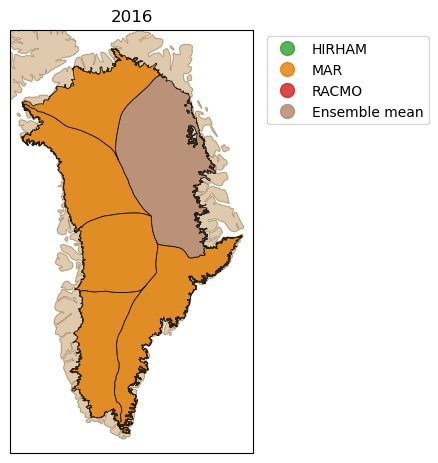

In [13]:
# Figure setup with the right projection (EPSG:3413)
fig, axs = plt.subplots(1, 1, figsize = (17.5,5.5), subplot_kw={'projection': cartopy.crs.Stereographic(
                                                                                        central_longitude=-45,
                                                                                        central_latitude=90,
                                                                                        true_scale_latitude=70)})
# plot results: 
plot_best_model(updated_basins_rignot, axs)
# Save figure 
fig.savefig(f'/home/annpug/Desktop/annpug/figures/basin_comparison_{type_dif}_{year}.png', bbox_inches="tight")

# Zwally et. al. drainage basins 

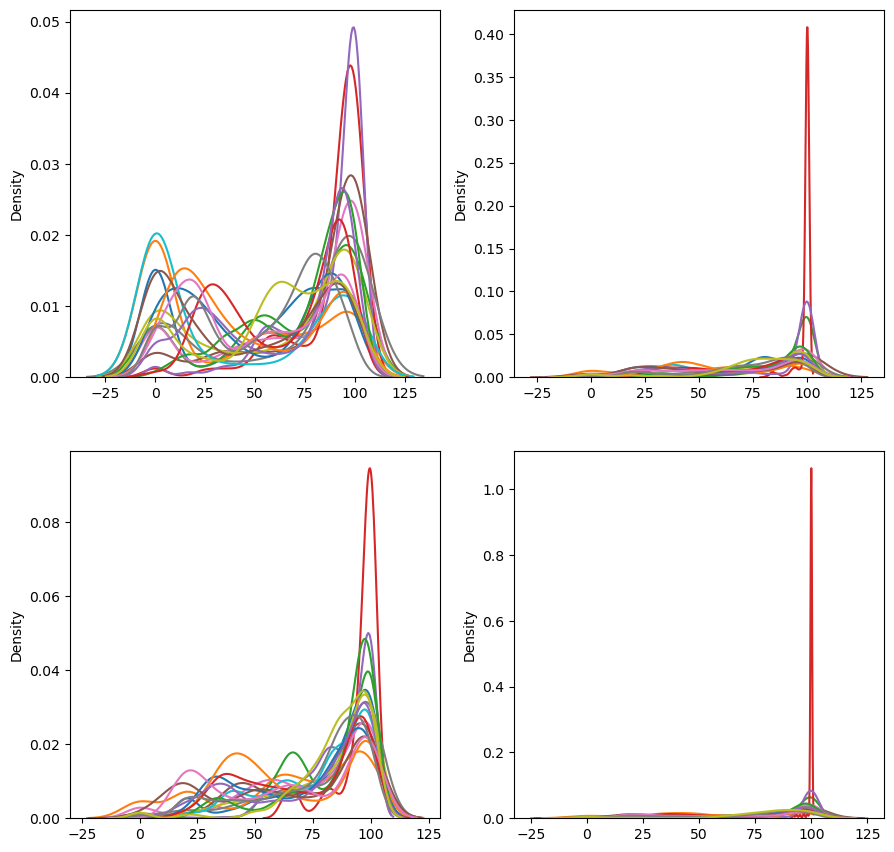

In [16]:
basin_mean_zwally = np.zeros((len(basins_zwally), 4))
basin_median_zwally =  np.zeros((len(basins_zwally), 4))
basin_std_zwally =  np.zeros((len(basins_zwally), 4))
fig, axs = plt.subplots(2, 2, figsize = (10.5,10.5))
axs = axs.ravel()
#fig, ax = plt.subplots(1, 1)
for i in range(len(basins_zwally)): 
    basin = basins_zwally.iloc[i]
    basin_mean_zwally[i,0], basin_median_zwally[i,0],basin_std_zwally[i,0], out_hirham = basin_statistics(basin.geometry, hirham_diff)
    basin_mean_zwally[i,1], basin_median_zwally[i,1],basin_std_zwally[i,1], out_racmo = basin_statistics(basin.geometry, racmo_diff)
    basin_mean_zwally[i,2], basin_median_zwally[i,2],basin_std_zwally[i,2], out_mar = basin_statistics(basin.geometry, mar_diff)
    basin_mean_zwally[i,3], basin_median_zwally[i,3],basin_std_zwally[i,3], out_ens = basin_statistics(basin.geometry, ens_mean_diff)
    #sns.kdeplot(data = out_image.flatten(), ax = ax, label = f'{basins_icesheet.SUBREGION1[i]}')
    
    sns.kdeplot(out_hirham.flatten(), ax=axs[0])
    sns.kdeplot(out_racmo.flatten(), ax=axs[1])
    sns.kdeplot(out_mar.flatten(), ax=axs[2])
    sns.kdeplot(out_ens.flatten(), ax=axs[3])


# Find the best model for each basin:
updated_basins_zwally = find_best_model_basins(basins_zwally, basin_mean_zwally, 'max')

## a) Plot of mean values for each basin 

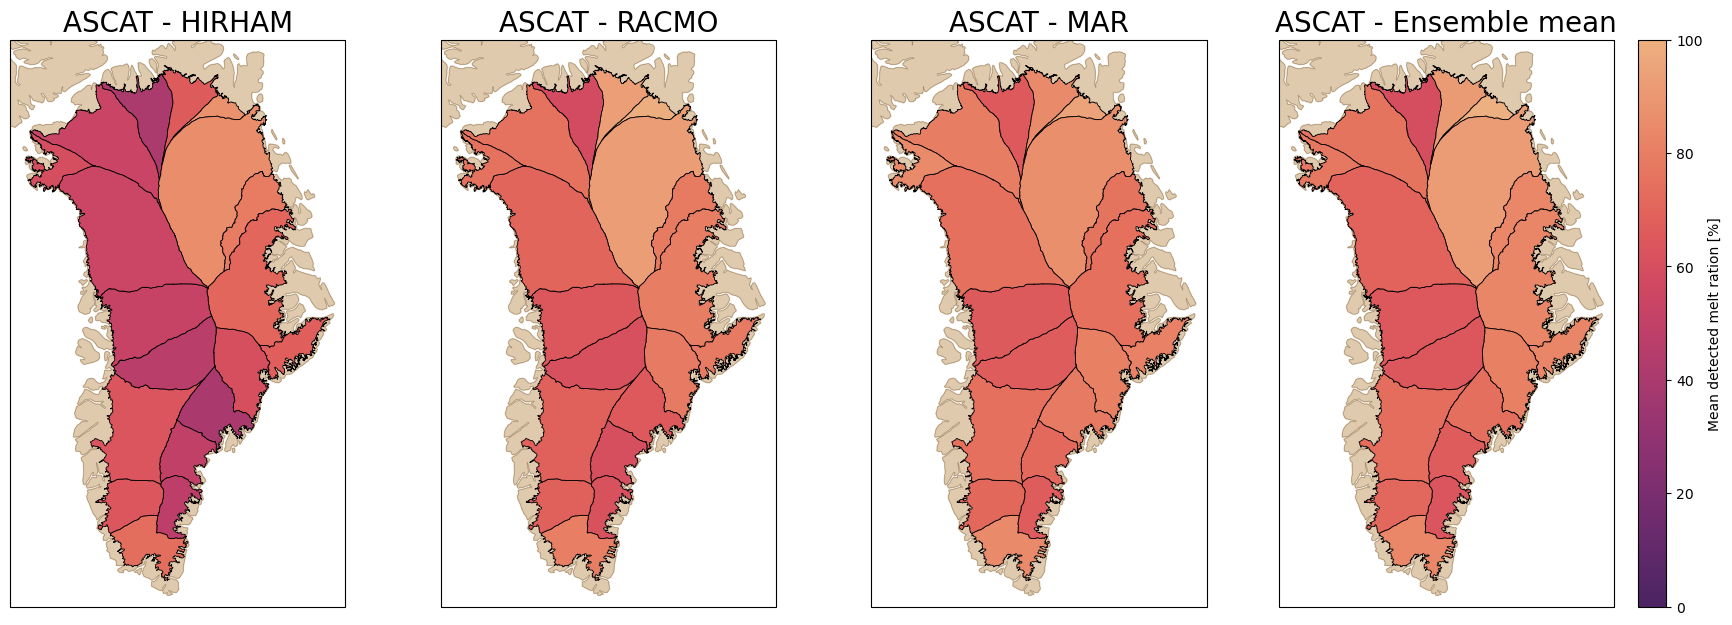

In [25]:
# Figure setup with the right projection (EPSG:3413)
fig, axs = plt.subplots(1, 4,  figsize = (17.5,5.5), subplot_kw={'projection': cartopy.crs.Stereographic(
                                                                                        central_longitude=-45,
                                                                                        central_latitude=90,
                                                                                        true_scale_latitude=70)})
# plot results: 
plot_basin_stats(updated_basins_zwally, "HIRHAM", axs[0], cmap, vmin, vmax)
plot_basin_stats(updated_basins_zwally, "RACMO", axs[1], cmap, vmin, vmax)
plot_basin_stats(updated_basins_zwally, "MAR", axs[2], cmap, vmin, vmax)
plot_basin_stats(updated_basins_zwally, "Ensemble mean", axs[3], cmap, vmin, vmax, 
                 legend = True, legend_label = "Mean detected melt ration [%]")


fig.tight_layout(pad = -2)
# Save figure 
fig.savefig(f'/home/annpug/Desktop/annpug/figures/basin_comparison_{type_dif}_{year}_zwally.png', bbox_inches="tight")
plt.show()

## b) Plot of best model for each basin

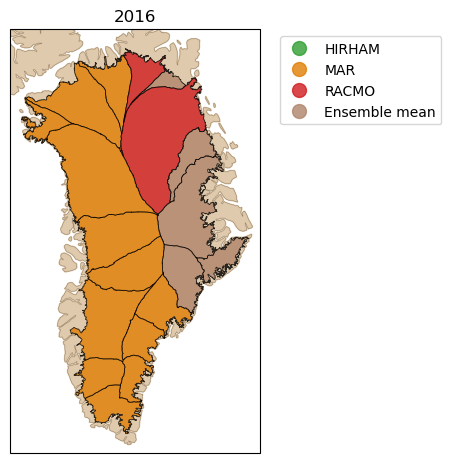

In [18]:
# Figure setup with the right projection (EPSG:3413)
fig, axs = plt.subplots(1, 1, figsize = (17.5,5.5), subplot_kw={'projection': cartopy.crs.Stereographic(
                                                                                        central_longitude=-45,
                                                                                        central_latitude=90,
                                                                                        true_scale_latitude=70)})
# plot and save: 
plot_best_model(updated_basins_zwally, axs)
fig.savefig(f'/home/annpug/Desktop/annpug/figures/basin_comparison_{type_dif}_{year}_zwally_best_model.png', bbox_inches="tight")